In this practical we are going to use dFBA to simulate aerobic batch growth of *Saccharomyces cerevisiae*. We will compare the results obtained using GEM and ecGEM to experimental data. Scripts are based on https://ami-journals.onlinelibrary.wiley.com/doi/full/10.1111/1751-7915.13995

In [1]:
import cobra
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
# Load experimetal data - t in h, biommass concentration in gDW/l and metabolite concentration in mM
data = pd.read_excel('batch_experimental_data.xls')
data

t  glucose [extracellular]  biomass [cytoplasm]  \
0    0.0                44.444444                 0.10   
1    1.0                41.666667                 0.10   
2    3.0                36.111111                 0.20   
3    4.5                26.111111                 0.50   
4    6.0                 8.333333                 0.75   
5    7.0                 0.000000                 1.20   
6    8.0                 0.000000                 1.20   
7    9.0                 0.000000                 1.25   
8   10.0                 0.000000                 1.35   
9   11.0                 0.000000                 1.50   
10  12.0                 0.000000                 1.50   
11  13.0                 0.000000                 2.20   

    ethanol [extracellular]  Unnamed: 4  Unnamed: 5  
0                  0.000000         NaN         NaN  
1                 21.739130         NaN         NaN  
2                 26.086957         NaN         NaN  
3                 34.782609         NaN         NaN  
4                 60.869565         NaN         NaN  
5                 67.391304         NaN         NaN  
6                 63.043478         NaN         NaN  
7                 60.869565         NaN         NaN  
8                 56.521739         NaN         NaN  
9                 43.478261         NaN         NaN  
10                32.608696         NaN         NaN  
11                21.739130         NaN         NaN

In [3]:
# Initial substrate (glucose), ethanol and biomass concentrations
cs_0 = 8/0.18 # mM
ce_0 = 0 # mM
cx_0 = 0.1 # gDW/l

# Time step for the simulation and final time point
dt = 0.5 # h
t_end = 15 # h

# Kinetic parameters
qs_max = 20  # mmol/gDW/h
kms =  0.28 # mM

In [4]:
# Load the models
gem = cobra.io.read_sbml_model("yeastGEM.xml")
ecgem = cobra.io.read_sbml_model("ecYeastGEM_batch.xml")

### Question 1: Understand, complete the batch function and answer the questions

We will run the simulations starting at t = 0h and until t_end. We do this using a while loop. Some code in the following sections is missing.

- Frist we create two dataframes (df) to store the concentration and flux data (all_con, all_flux)
- We can get the glucose concentration at the last simulated time point in the all_con df using the following command: all_con['glucose [extracellular]'].iloc[-1]
- Calculate qs and set as lower/upper bound:
    - **Fill in the equation for qs using the Michaelis Menten equation**
    - **If we use a traditional GEM, should qs be the lower or upper bound of the glucose exchange reaction? And if we use an ecGEM?**
- Ethanol uptake: we only allow ethanol uptake when ethanol is present in the media
    - Notice that instead of using a kinetic equation for ethanol uptake, we use a constant value (5 mmol/gDW/h)
- Perform FBA: if the solution is infeasible we break the loop
- Calculate cs at the next tim step (t = t+dt):
    - **Fill in the equation for cs.** Tips:
        - cs(t) = all_con['glucose [extracellular]'].iloc[-1] 
        - cx(t) = all_con['biomass [cytoplasm]'].iloc[-1]
        - qs = solution.fluxes[glc_exc_id]
    - Notice that, if we consider glucose concentrations below 0.001 equal to 0
- Find active exchange reactions:
    - Notice that we select the exchange reactions considering that they are the only reactions that only involve one metabolite
    - **How do you get the FBA predicted flux through a reaction?**
    - Notice that we save the flux through active reactions in df_flux
- Calculate concentrations of excreted products
    - **Fill in the value for cx at time t**
    - **Can you write the mass balance for the metabolites?**
- Calculate ethanol concentration: special case because it can be excreted or consumed
    - **Can you write the mass balance?** Consider that there is only one reaction for ethanol exchange in the traditional GEM but a forward and reverse reaction in ecGEM

In [5]:
def batch(model, gecko, cs_0, cx_0, ce_0, dt, glc_exc_id, growth_id, qs_max, kms, t_end):
    all_con = pd.DataFrame({'t': [0],
                            'glucose [extracellular]': [cs_0],
                            'biomass [cytoplasm]': [cx_0],
                            'ethanol [extracellular]': [ce_0]
                              })
    all_flux = pd.DataFrame({'t': [0]})
    t = 0
    while t < t_end:
        # Up-date the time
        t = t + dt

        # Create two temporal df to store the data for this timepoiny
        df_con = pd.DataFrame()
        df_flux = pd.DataFrame()


        # Calculate qs and set as lower/upper bound 
        cs = all_con['glucose [extracellular]'].iloc[-1]
        qs = qs_max * cs/(kms+cs)
        if gecko == False:
            model.reactions.get_by_id(glc_exc_id).lower_bound = -qs
        else:
            if qs < 0:
                qs = 0
            model.reactions.get_by_id(glc_exc_id).upper_bound = qs

        # ETH uptake: only allow ethanol uptake if it is present in the media
        E = all_con['ethanol [extracellular]'].iloc[-1]
        if E > 0:
            if gecko == False:
                model.reactions.r_1761.lower_bound = -5
            else:
                model.reactions.r_1761_REV.upper_bound = 5
        else:
            if gecko == False:
                model.reactions.r_1761.lower_bound = 0
            else:
                model.reactions.r_1761_REV.upper_bound = 0

        # Perform FBA
        model.objective = growth_id
        model.objective.direction = 'max'
        try:
            solution = model.optimize()
        except (UserWarning) as e:
            print('Solution infeasible, t =', t)
            break

        # Calculate cs at t = t+dt
        cs = (
            all_con['glucose [extracellular]'].iloc[-1] 
            - dt * abs(solution.fluxes[glc_exc_id]) 
            * all_con['biomass [cytoplasm]'].iloc[-1]
        )

        if cs < 1E-3:
            cs = 0

        # Find active exchange reactions 
        for reaction in model.reactions:
            reaction_id = reaction.id
            if len(model.reactions.get_by_id(reaction_id).metabolites) == 1: 
                flux = solution.fluxes[reaction_id]
                if abs(flux) > 1e-6:
                    df_flux[reaction_id] = [flux]

        # Calculate new concentrations of excreted products
        cx = all_con['biomass [cytoplasm]'].iloc[-1]
        for reaction in df_flux.columns:
            if reaction == 't':
                continue
            elif gecko == False:
                if solution.fluxes[reaction] > 0:
                    for m in model.reactions.get_by_id(reaction).metabolites:
                        metabolite = m.name
                        try:
                            cm = all_con[metabolite].iloc[-1]
                        except (KeyError) as e:
                            cm = 0
                        df_con[metabolite] = [(cm + dt*solution.fluxes[reaction]*cx)]
            else:
                if 'REV' in reaction or 'pool' in reaction:
                    continue
                else:
                    for m in model.reactions.get_by_id(reaction).metabolites:
                        metabolite = m.name
                        try:
                            cm = all_con[metabolite].iloc[-1]
                        except (KeyError) as e:
                            cm = 0
                        df_con[metabolite] = [cm + dt*solution.fluxes[reaction]*cx]

        # Calculate ethanol concentration
        if gecko == False:
            df_con['ethanol [extracellular]'] = [all_con['ethanol [extracellular]'].iloc[-1]
                                                + dt*solution.fluxes['r_1761']*cx]
        else:
            df_con['ethanol [extracellular]'] = [all_con['ethanol [extracellular]'].iloc[-1]
                                                + dt*solution.fluxes['r_1761']*cx
                                                - dt*solution.fluxes['r_1761_REV']*cx]

        # Save results
        for column in all_con.columns:
            try:
                con = df_con[column].iloc[-1]
                if np.isnan(con):
                    df_con[column] = all_con[column].iloc[-1]
            except (KeyError) as e:
                df_con[column] = all_con[column].iloc[-1]
        df_con['glucose [extracellular]'] = [cs]
        df_flux['t'] = [t]
        df_con['t'] = [t]
        all_con = all_con.append(df_con, sort=False)
        all_flux = all_flux.append(df_flux, sort=False)
    return all_con, all_flux

### Question 2: Run simulations with the GEM and ecGEM models

- Which simulation is more similar to the experimental data?

In [6]:
# GEM simulation
con_gem, flux_gem = batch(
    model=gem, 
    gecko=False, 
    cs_0=cs_0, 
    cx_0=cx_0, 
    ce_0=ce_0, 
    dt=dt,
    glc_exc_id='r_1714', 
    growth_id='r_2111', 
    qs_max=qs_max, 
    kms=kms, 
    t_end=t_end
)
display(con_gem.head(5))
display(flux_gem.head(5))

C:\Users\moren021\Anaconda3\lib\site-packages\cobra\util\solver.py:554: UserWarning: Solver status is 'infeasible'.
  warn(f"Solver status is '{status}'.", UserWarning)


t  glucose [extracellular]  biomass [cytoplasm]  ethanol [extracellular]  \
0  0.0                44.444444             0.100000                      0.0   
0  0.5                43.450705             0.190316                      0.0   
0  1.0                41.559732             0.362177                      0.0   
0  1.5                37.962205             0.689137                      0.0   
0  2.0                31.121292             1.310871                      0.0   

   carbon dioxide [extracellular]  glycolaldehyde [extracellular]  \
0                             NaN                             NaN   
0                        2.279548                        0.000006   
0                        6.617271                        0.000017   
0                       14.869683                        0.000038   
0                       30.562164                        0.000078   

   H2O [extracellular]  (S)-3-methyl-2-oxopentanoate [extracellular]  \
0                  NaN                                           NaN   
0             3.827324                                           NaN   
0            11.110285                                           NaN   
0            24.965937                                           NaN   
0            51.313300                                           NaN   

   3-methylbutanal [extracellular]  ammonium [extracellular]  ...  \
0                              NaN                       NaN  ...   
0                              NaN                       NaN  ...   
0                              NaN                       NaN  ...   
0                              NaN                       NaN  ...   
0                              NaN                       NaN  ...   

   urea [extracellular]  2-aminobutanoate [extracellular]  \
0                   NaN                               NaN   
0                   NaN                               NaN   
0                   NaN                               NaN   
0                   NaN                               NaN   
0                   NaN                               NaN   

   L-Methionine S-oxide [extracellular]  UMP [extracellular]  \
0                                   NaN                  NaN   
0                                   NaN                  NaN   
0                                   NaN                  NaN   
0                                   NaN                  NaN   
0                                   NaN                  NaN   

   CMP [extracellular]  chloride [extracellular]  Cu2(+) [extracellular]  \
0                  NaN                       NaN                     NaN   
0                  NaN                       NaN                     NaN   
0                  NaN                       NaN                     NaN   
0                  NaN                       NaN                     NaN   
0                  NaN                       NaN                     NaN   

   Mn(2+) [extracellular]  Zn(2+) [extracellular]  Mg(2+) [extracellular]  
0                     NaN                     NaN                     NaN  
0                     NaN                     NaN                     NaN  
0                     NaN                     NaN                     NaN  
0                     NaN                     NaN                     NaN  
0                     NaN                     NaN                     NaN  

[5 rows x 32 columns]

t     r_1654     r_1672     r_1714    r_1814     r_1832    r_1861  \
0  0.0        NaN        NaN        NaN       NaN        NaN       NaN   
0  0.5 -11.513667  45.590967 -19.874789  0.000117 -15.514895 -0.000057   
0  1.0 -11.512016  45.584458 -19.871944  0.000117 -15.512674 -0.000057   
0  1.5 -11.508657  45.571219 -19.866156  0.000117 -15.508159 -0.000057   
0  2.0 -11.501351  45.542415 -19.853565  0.000117 -15.498334 -0.000057   

      r_1992    r_2005    r_2020  ...  r_1870  r_1893  r_1900  r_2061  r_2073  \
0        NaN       NaN       NaN  ...     NaN     NaN     NaN     NaN     NaN   
0 -41.972820 -0.503445 -0.006557  ...     NaN     NaN     NaN     NaN     NaN   
0 -41.966830 -0.503373 -0.006556  ...     NaN     NaN     NaN     NaN     NaN   
0 -41.954645 -0.503226 -0.006554  ...     NaN     NaN     NaN     NaN     NaN   
0 -41.928138 -0.502907 -0.006550  ...     NaN     NaN     NaN     NaN     NaN   

   r_2091  r_4520  r_4550  r_4557  r_4558  
0     NaN     NaN     NaN     NaN     NaN  
0     NaN     NaN     NaN     NaN     NaN  
0     NaN     NaN     NaN     NaN     NaN  
0     NaN     NaN     NaN     NaN     NaN  
0     NaN     NaN     NaN     NaN     NaN  

[5 rows x 36 columns]

In [7]:
con_ecgem, flux_ecgem = batch(
    model=ecgem, 
    gecko=True, 
    cs_0=cs_0, 
    cx_0=cx_0, 
    ce_0=ce_0, 
    dt=dt,
    glc_exc_id='r_1714_REV', 
    growth_id='r_2111', 
    qs_max=qs_max, 
    kms=kms, 
    t_end=t_end
)
display(con_ecgem.head(5))
display(flux_ecgem.head(5))

t  glucose [extracellular]  biomass [cytoplasm]  ethanol [extracellular]  \
0  0.0                44.444444             0.100000                 0.000000   
0  0.5                43.646185             0.116289                 1.349150   
0  1.0                42.717894             0.135232                 2.918067   
0  1.5                41.638390             0.157261                 4.742550   
0  2.0                40.383043             0.182877                 6.864230   

   bicarbonate [extracellular]  carbon dioxide [extracellular]  \
0                          NaN                             NaN   
0                     0.003887                        1.483853   
0                     0.008406                        3.209416   
0                     0.013662                        5.216062   
0                     0.019774                        7.549577   

   formate [extracellular]  H2O [extracellular]  
0                      NaN                  NaN  
0                 0.000504             0.417406  
0                 0.001090             0.902804  
0                 0.001772             1.467271  
0                 0.002564             2.123686

t    r_1663    r_1672     r_1761    r_1793    r_2100    r_2111  \
0  0.0       NaN       NaN        NaN       NaN       NaN       NaN   
0  0.5  0.077732  29.67706  26.982991  0.010079  8.348116  0.325787   
0  1.0  0.077732  29.67706  26.982991  0.010079  8.348116  0.325787   
0  1.5  0.077732  29.67706  26.982991  0.010079  8.348116  0.325787   
0  2.0  0.077732  29.67706  26.982991  0.010079  8.348116  0.325787   

   r_1654_REV  r_1714_REV  r_1992_REV  r_2005_REV  r_2060_REV  \
0         NaN         NaN         NaN         NaN         NaN   
0     2.20354   15.965194    2.215175    0.077732    0.029794   
0     2.20354   15.965194    2.215175    0.077732    0.029794   
0     2.20354   15.965194    2.215175    0.077732    0.029794   
0     2.20354   15.965194    2.215175    0.077732    0.029794   

   prot_pool_exchange  r_1761_REV  
0                 NaN         NaN  
0            0.074701         NaN  
0            0.074701         NaN  
0            0.074701         NaN  
0            0.074701         NaN

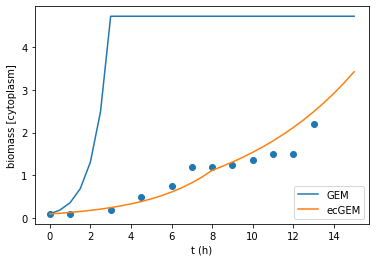

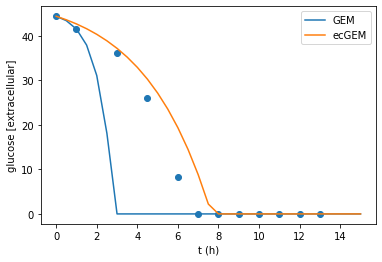

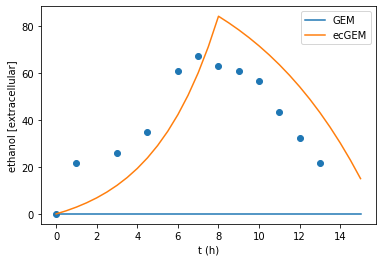

In [8]:
for plotting in ['biomass [cytoplasm]', 'glucose [extracellular]', 'ethanol [extracellular]']:
    plt.plot(con_gem['t'], con_gem[plotting], label='GEM')
    plt.plot(con_ecgem['t'], con_ecgem[plotting], label='ecGEM')
    plt.scatter(data['t'], data[plotting])
    plt.xlabel('t (h)')
    plt.ylabel(plotting)
    plt.legend()
    plt.show()

### Question 3: Try different values for qs_max and simulate both models
- Which model is most affected by this change? Why?

In [9]:
# Try higher qs_max
qs_max = qs_max*10
con_gem1, flux_gem1 = batch(
    model=gem, 
    gecko=False, 
    cs_0=cs_0, 
    cx_0=cx_0, 
    ce_0=ce_0, 
    dt=dt,
    glc_exc_id='r_1714', 
    growth_id='r_2111', 
    qs_max=qs_max, 
    kms=kms, 
    t_end=t_end
)
con_ecgem1, flux_ecgem1 = batch(
    model=ecgem, 
    gecko=True, 
    cs_0=cs_0, 
    cx_0=cx_0, 
    ce_0=ce_0, 
    dt=dt,
    glc_exc_id='r_1714_REV', 
    growth_id='r_2111', 
    qs_max=qs_max, 
    kms=kms, 
    t_end=t_end
)
# Try lower qs_max
qs_max = qs_max/100
con_gem2, flux_gem2 = batch(
    model=gem, 
    gecko=False, 
    cs_0=cs_0, 
    cx_0=cx_0, 
    ce_0=ce_0, 
    dt=dt,
    glc_exc_id='r_1714', 
    growth_id='r_2111', 
    qs_max=qs_max, 
    kms=kms, 
    t_end=t_end
)
con_ecgem2, flux_ecgem2 = batch(
    model=ecgem, 
    gecko=True, 
    cs_0=cs_0, 
    cx_0=cx_0, 
    ce_0=ce_0, 
    dt=dt,
    glc_exc_id='r_1714_REV', 
    growth_id='r_2111', 
    qs_max=qs_max, 
    kms=kms, 
    t_end=t_end
)
# Restore the qs_max value
qs_max = 20

C:\Users\moren021\Anaconda3\lib\site-packages\cobra\util\solver.py:554: UserWarning: Solver status is 'infeasible'.
  warn(f"Solver status is '{status}'.", UserWarning)


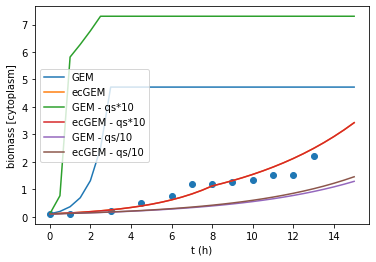

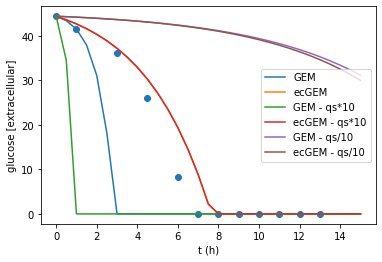

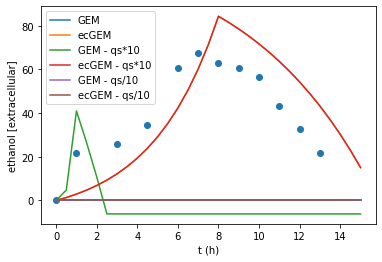

In [10]:
for plotting in ['biomass [cytoplasm]', 'glucose [extracellular]', 'ethanol [extracellular]']:
    plt.plot(con_gem['t'], con_gem[plotting], label='GEM')
    plt.plot(con_ecgem['t'], con_ecgem[plotting], label='ecGEM')
    plt.plot(con_gem1['t'], con_gem1[plotting], label='GEM - qs*10')
    plt.plot(con_ecgem1['t'], con_ecgem1[plotting], label='ecGEM - qs*10')
    plt.plot(con_gem2['t'], con_gem2[plotting], label='GEM - qs/10')
    plt.plot(con_ecgem2['t'], con_ecgem2[plotting], label='ecGEM - qs/10')
    plt.scatter(data['t'], data[plotting])
    plt.xlabel('t (h)')
    plt.ylabel(plotting)
    plt.legend()
    plt.show()

### Question 4: Which parameter will have a big effect on ecGEM simulations?

Try different values for this parameter and check how the predictions change.

In [11]:
pp_ub = ecgem.reactions.prot_pool_exchange.upper_bound

In [12]:
# Increase the protein pool upper bound
ecgem.reactions.prot_pool_exchange.upper_bound = pp_ub*10
con_ecgem1, flux_ecgem1 = batch(
    model=ecgem, 
    gecko=True, 
    cs_0=cs_0, 
    cx_0=cx_0, 
    ce_0=ce_0, 
    dt=dt,
    glc_exc_id='r_1714_REV', 
    growth_id='r_2111', 
    qs_max=qs_max, 
    kms=kms, 
    t_end=t_end
)
# Decrease the protein pool upper bound
ecgem.reactions.prot_pool_exchange.upper_bound = pp_ub/10
con_ecgem2, flux_ecgem2 = batch(
    model=ecgem, 
    gecko=True, 
    cs_0=cs_0, 
    cx_0=cx_0, 
    ce_0=ce_0, 
    dt=dt,
    glc_exc_id='r_1714_REV', 
    growth_id='r_2111', 
    qs_max=qs_max, 
    kms=kms, 
    t_end=t_end
)
# Restore the prot pool upper bound
ecgem.reactions.prot_pool_exchange.upper_bound = pp_ub

C:\Users\moren021\Anaconda3\lib\site-packages\cobra\util\solver.py:554: UserWarning: Solver status is 'infeasible'.
  warn(f"Solver status is '{status}'.", UserWarning)


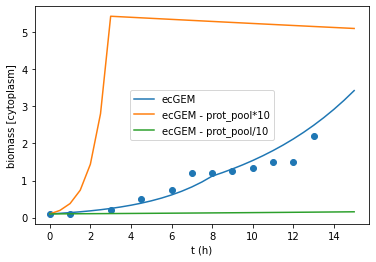

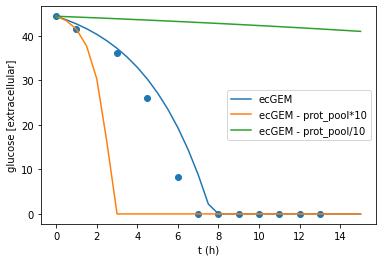

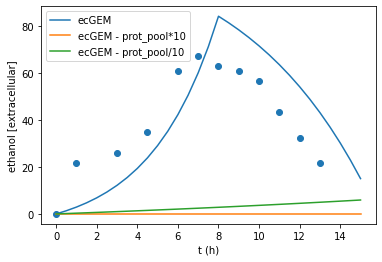

In [13]:
for plotting in ['biomass [cytoplasm]', 'glucose [extracellular]', 'ethanol [extracellular]']:
    plt.plot(con_ecgem['t'], con_ecgem[plotting], label='ecGEM')
    plt.plot(con_ecgem1['t'], con_ecgem1[plotting], label='ecGEM - prot_pool*10')
    plt.plot(con_ecgem2['t'], con_ecgem2[plotting], label='ecGEM - prot_pool/10')
    plt.scatter(data['t'], data[plotting])
    plt.xlabel('t (h)')
    plt.ylabel(plotting)
    plt.legend()
    plt.show()